In [1]:
%matplotlib inline
from IPython.core.pylabtools import figsize
import numpy as np


from matplotlib import pyplot as plt
figsize(11, 9)

import matplotlib as mpl

plt.style.use('ggplot')

# plt.style.use('seaborn-darkgrid')
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['grid.linewidth'] = 1
mpl.rcParams['grid.color'] = 'grey'
mpl.rcParams['grid.alpha'] = .5

import scipy.stats as stats
import pymc3 as pm
import theano.tensor as T
import pandas as pd

## Kicking

In [12]:
# Import data
data_path = '/Users/ryand/Desktop/kicking.csv'
df = pd.read_csv(data_path)

# Filtering and forming np array
df['kicking_dist'] = df['kicking_fgm_yds'] + df['kicking_fgmissed_yds']
df['kicking_result'] = np.where(df['kicking_fgm']==1, 0, 1)
data = df[['kicking_dist','kicking_result']].to_numpy()

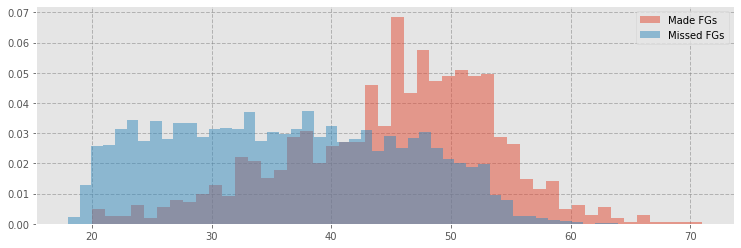

In [9]:
def logistic(x, beta, alpha=0):
    return 1.0 / (1.0 + np.exp(np.dot(beta, x) + alpha))

figsize(12.5, 4)
bins = data[:,0].max()-data[:,0].min()-6

plt.figure()
plt.hist(data[data[:,1]==1][:,0], bins=bins, density=True,
         label='Made FGs', alpha=.5)
plt.hist(data[data[:,1]==0][:,0], bins=bins, density=True,
         label='Missed FGs', alpha=.5)
plt.legend();

In [10]:
# Run Bayesian model
sample_size = 100000

yardage = data[:, 0]
res_ = data[:, 1]

with pm.Model() as model:
    beta = pm.Normal("beta", mu=0, tau=0.001, testval=0)
    alpha = pm.Normal("alpha", mu=0, tau=0.001, testval=0)
    
    # Deterministic Logistic function
    p = pm.Deterministic("p", 1.0/(1. + T.exp(beta*yardage + alpha)))
    
    observed = pm.Bernoulli("bernoulli_obs", p, observed=res_)
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(sample_size, step=step, start=start)
    burned_trace = trace[sample_size/2::2]

logp = -3,541.4, ||grad|| = 1.7702: 100%|██████████| 23/23 [00:00<00:00, 523.91it/s]  
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [alpha]
>Metropolis: [beta]
Sampling 2 chains, 0 divergences:   6%|▌         | 11626/201000 [00:17<04:47, 658.39draws/s]


KeyboardInterrupt: 

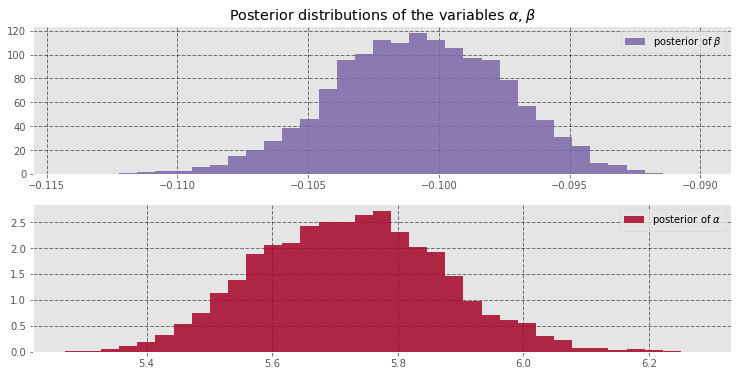

In [13]:
alpha_samples = burned_trace["alpha"][:, None]  # best to make them 1d
beta_samples = burned_trace["beta"][:, None]

figsize(12.5, 6)

#histogram of the samples:
plt.subplot(211)
plt.title(r"Posterior distributions of the variables $\alpha, \beta$")
plt.hist(beta_samples, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\beta$", color="#7A68A6", density=True)
plt.legend()

plt.subplot(212)
plt.hist(alpha_samples, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\alpha$", color="#A60628", density=True)
plt.legend();

In [14]:
t = np.linspace(yardage.min() - 5, yardage.max() + 5, 50)[:, None]
p_t = logistic(t.T, beta_samples, alpha_samples)

mean_prob_t = p_t.mean(axis=0)

In [155]:
beta_samples

array([[-0.10367537],
       [-0.10367537],
       [-0.10367537],
       ...,
       [-0.10813763],
       [-0.10813763],
       [-0.10813763]])

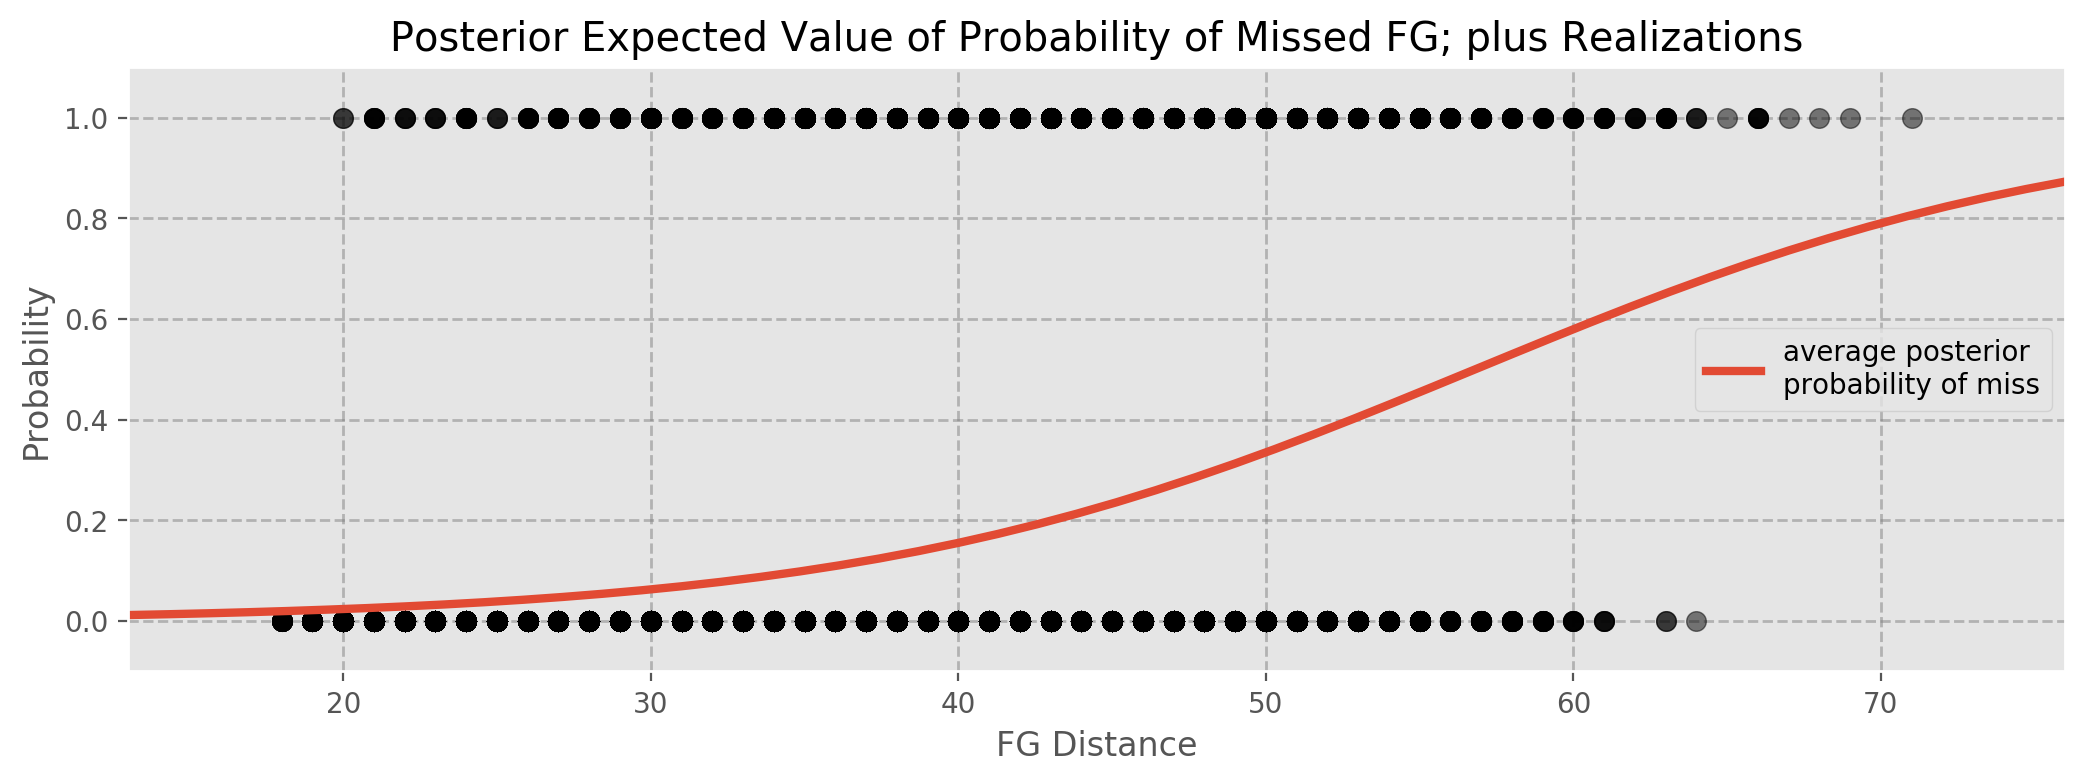

In [88]:
figsize(12.5, 4)
plt.subplots(dpi=200)

plt.plot(t, mean_prob_t, lw=3, label="average posterior \nprobability \
of miss")
# plt.plot(t, p_t[0, :], ls="--", label="realization from posterior")
# plt.plot(t, p_t[-2, :], ls="--", label="realization from posterior")
plt.scatter(yardage, re, color="k", s=50, alpha=0.5)
plt.title("Posterior Expected Value of Probability of Missed FG; \
plus Realizations")
plt.legend(loc="right")
plt.ylim(-0.1, 1.1)
plt.xlim(t.min(), t.max())
plt.ylabel("Probability")
plt.xlabel("FG Distance");

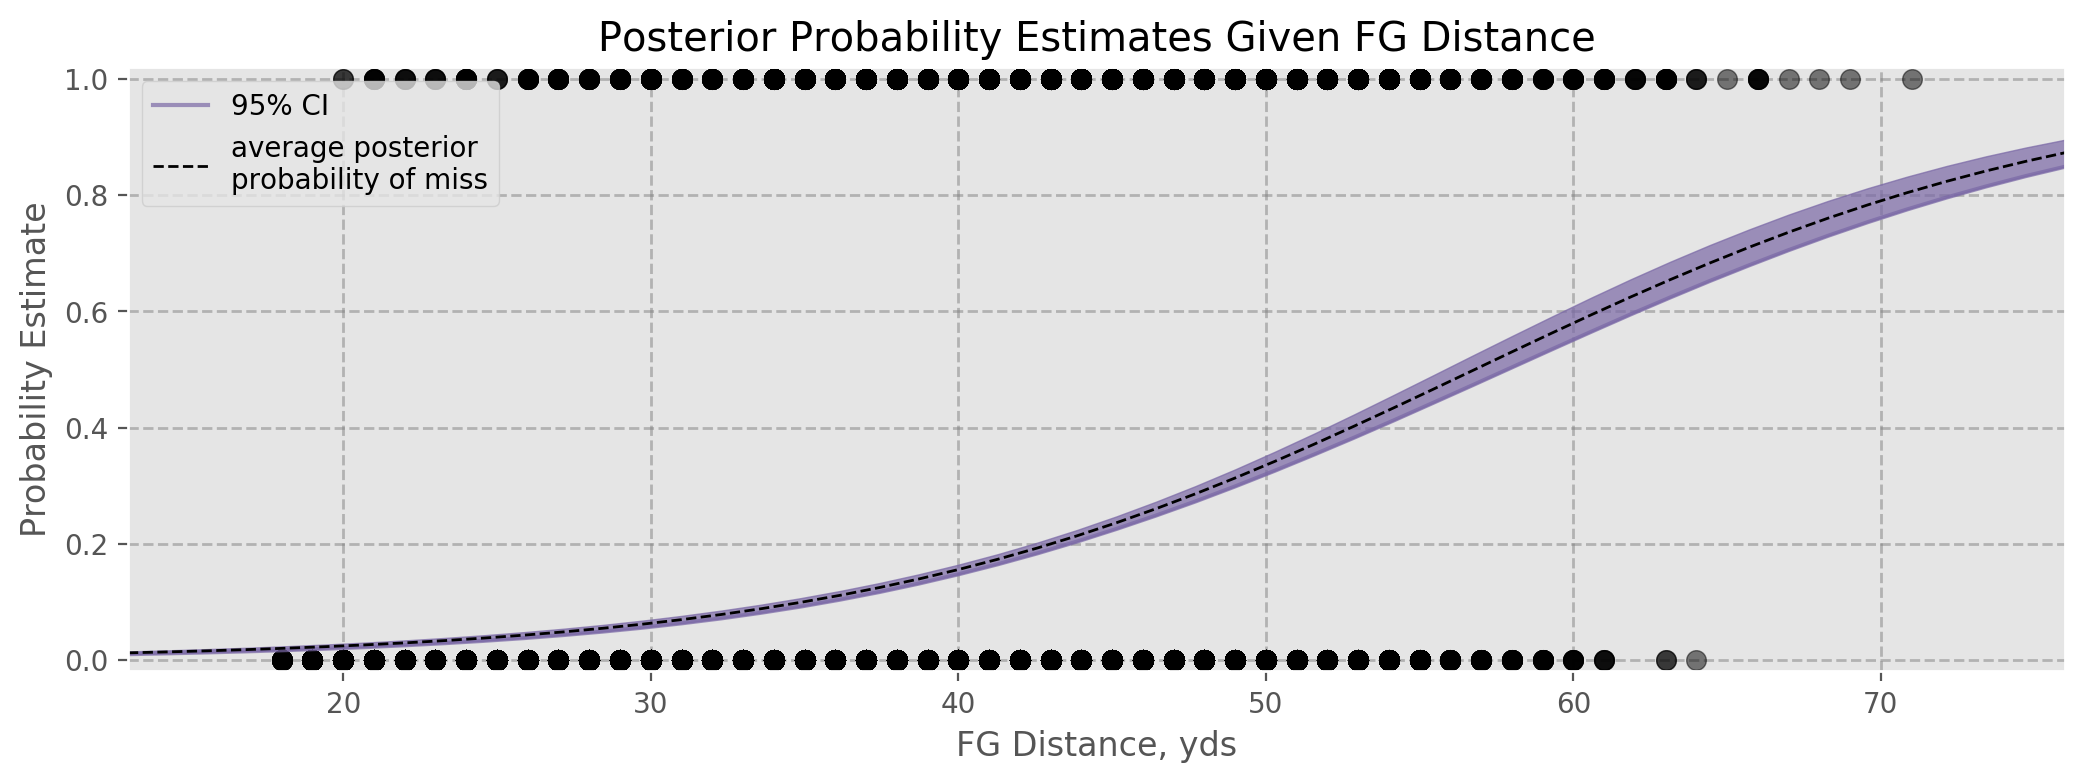

In [93]:
from scipy.stats.mstats import mquantiles

# vectorized bottom and top 2.5% quantiles for "confidence interval"
qs = mquantiles(p_t, [0.025, 0.975], axis=0)
figsize(12.5, 4)
plt.subplots(dpi=200)
plt.fill_between(t[:, 0], *qs, alpha=0.7,
                 color="#7A68A6")

plt.plot(t[:, 0], qs[0], label="95% CI", color="#7A68A6", alpha=0.7)

plt.plot(t, mean_prob_t, lw=1, ls="--", color="k",
         label="average posterior \nprobability of miss")

plt.xlim(t.min(), t.max())
plt.ylim(-0.02, 1.02)
plt.legend(loc="best")
plt.scatter(yardage, res_, color="k", s=50, alpha=0.5)
plt.xlabel("FG Distance, yds")

plt.ylabel("Probability Estimate")
plt.title("Posterior Probability Estimates Given FG Distance");

In [102]:
obs_outcomes = pd.DataFrame(data, columns=['yds','outcome']).groupby('yds').agg({'outcome':['sum','count']})['outcome']

In [106]:
obs_per = (obs_outcomes['count']-obs_outcomes['sum'])/obs_outcomes['count']

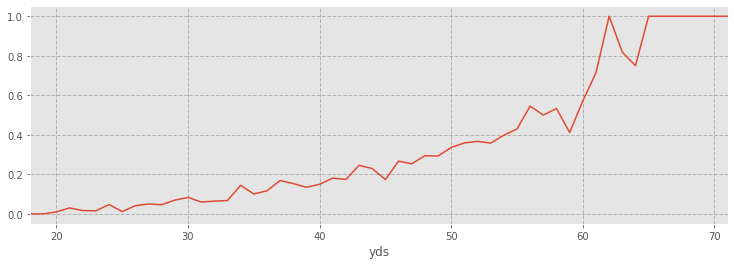

In [110]:
(1-obs_per).plot()

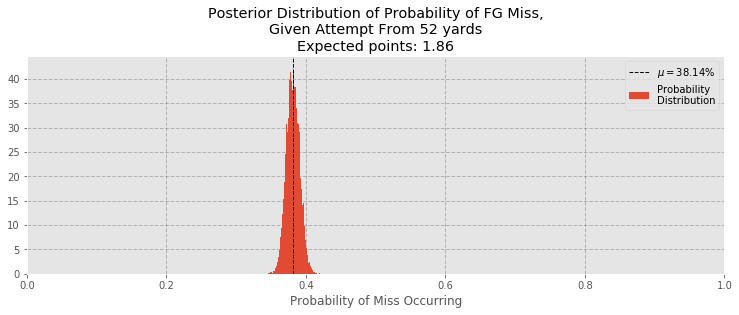

In [153]:
distance = 52

figsize(12.5, 4)

prob_ = logistic(distance, beta_samples, alpha_samples)
e_p = (1-prob_.mean())*3

plt.xlim(0.0, 1)
plt.hist(prob_, bins=100, density=True, histtype='stepfilled',
         label="Probability\nDistribution")
plt.title("""Posterior Distribution of Probability of FG Miss,
Given Attempt From {} yards
Expected points: {}""".format(distance,round(e_p,2)))
plt.xlabel("Probability of Miss Occurring")
plt.axvline(prob_.mean(), color='k', ls='--',lw=1, 
            label='$\mu =${}%'.format(round(prob_.mean()*100,2)))
plt.legend();

# Expected Points Model
___

In [1]:
%matplotlib inline
from IPython.core.pylabtools import figsize
import numpy as np


from matplotlib import pyplot as plt
figsize(11, 9)

import matplotlib as mpl

plt.style.use('ggplot')

# plt.style.use('seaborn-darkgrid')
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['grid.linewidth'] = 1
mpl.rcParams['grid.color'] = 'grey'
mpl.rcParams['grid.alpha'] = .5

import scipy.stats as stats
import pymc3 as pm
import theano.tensor as T
import pandas as pd

In [2]:
_down = [1,2,3,4]
_distance = range(100)
_field_pos = range(100)

## Model Thoughts
———————————————————
* Inputs: field position, down, distance
* Output: **E**(_pts_) of different 
* Output Function: 
* Loss function: should effectively be the **E**(_pts_) for the **opposing** team given field position and a 1<sup>st</sup> & 10

## Data Prep

In [3]:
play = pd.read_csv('/Users/ryand/Desktop/play_table.csv')

In [4]:
start = play[play['note']!='KICKOFF'][
    ['gsis_id','drive_id','play_id','pos_team']].groupby(
    ['gsis_id','drive_id','pos_team']).min().reset_index()
end = play[(play['note']!='XP') 
           & (play['note']!='KICKOFF')][
    ['gsis_id','drive_id','play_id','pos_team']].groupby(
    ['gsis_id','drive_id','pos_team']).max().reset_index()

start['start'] = 1
end['end'] = 1

play_s_e = play.merge(start, on=['gsis_id','drive_id','pos_team','play_id'],
                    how='left').merge(end, on=['gsis_id','drive_id','pos_team','play_id'],
                    how='left').sort_values(['gsis_id','drive_id','play_id'])

In [5]:
play_s_e[['note','start','end']].groupby(['note']).sum().sort_values(['start'])

,start,end
note,,
XPM,0.0,110.0
2PR,0.0,95.0
XPA,0.0,9.0
PUNTB,0.0,67.0
FGB,0.0,170.0
XPB,0.0,48.0
KICKOFF,0.0,0.0
2PRF,1.0,65.0
2PPF,2.0,228.0


In [6]:
drive_sum = play_s_e[(play_s_e[['start','end']].sum(axis=1)>0) 
         & (play_s_e['note']!='KICKOFF') 
         & (play_s_e['pos_team']!='UNK')]

In [7]:
pts = {'TD':7,'FG':3}

drive_cond = drive_sum.sort_values(['gsis_id','drive_id','play_id']).groupby(
    ['gsis_id','drive_id','pos_team']
).agg({'yardline':'first','note':'last'})

drive_cond['pts'] = drive_cond['note'].apply(lambda x: pts[x] if x in list(pts.keys()) else 0)
drive_cond['yardline'] = drive_cond['yardline'].apply(lambda x: int(x.strip('()'))+50)

## Model

In [8]:
data = drive_cond[['yardline','pts']].to_numpy()

In [ ]:
# Run model
sample_size = 20000

yardage = data[:, 0]
res_ = data[:, 1]

with pm.Model() as model:
    beta = pm.Normal("beta", mu=0, tau=0.001, testval=0)
    alpha = pm.Normal("alpha", mu=0, tau=0.001, testval=0)
    
    # Deterministic Logistic function
    p = pm.Deterministic("p", 1.0/(1. + T.exp(beta*yardage + alpha)))
    
    observed = pm.Bernoulli("bernoulli_obs", p, observed=res_)
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(sample_size, step=step, start=start)

logp = -inf, ||grad|| = 4.8975e+05: 100%|██████████| 3/3 [00:00<00:00, 213.93it/s]
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [alpha]
>Metropolis: [beta]
Sampling 2 chains, 0 divergences: 100%|██████████| 41000/41000 [02:52<00:00, 237.24draws/s]


In [ ]:
alpha_samples = trace["alpha"][:, None]  # best to make them 1d
beta_samples = trace["beta"][:, None]

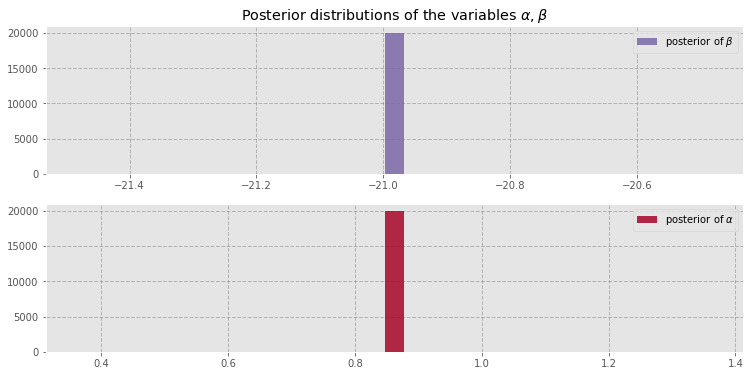

In [13]:
figsize(12.5, 6)

#histogram of the samples:
plt.subplot(211)
plt.title(r"Posterior distributions of the variables $\alpha, \beta$")
plt.hist(beta_samples, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\beta$", color="#7A68A6")#, density=True)
plt.legend()

plt.subplot(212)
plt.hist(alpha_samples, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\alpha$", color="#A60628")#, density=True)
plt.legend();